## Load Pre Processed Dataset

In [1]:
import zipfile
import pandas as pd

with zipfile.ZipFile("/content/drive/MyDrive/Student/Mohit/Dataset/Skin_Cancer_Malignant_vs_Benign/archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")


train_load_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/train_df.csv'
test_load_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/test_df.csv'
val_load_path = '/content/drive/MyDrive/Student/Mohit/Dataset/Federated_Learning_Project_2/Processed_CSV/val_df.csv'

# Loading dataframes from the CSV files
train_df = pd.read_csv(train_load_path)
test_df = pd.read_csv(test_load_path)
val_df = pd.read_csv(val_load_path)

print("Train DataFrame:")
display(train_df)

print("\nTest DataFrame:")
display(test_df)

print("\nValidation DataFrame:")
display(val_df)

Train DataFrame:


,file_path,label
0,/content/data/train/benign/183.jpg,benign
1,/content/data/train/benign/852.jpg,benign
2,/content/data/train/benign/1515.jpg,benign
3,/content/data/train/benign/807.jpg,benign
4,/content/data/train/benign/1580.jpg,benign
...,...,...
2632,/content/data/train/malignant/685.jpg,malignant
2633,/content/data/train/malignant/1481.jpg,malignant
2634,/content/data/train/malignant/1247.jpg,malignant
2635,/content/data/train/malignant/550.jpg,malignant



Test DataFrame:


,file_path,label
0,/content/data/test/benign/878.jpg,benign
1,/content/data/test/malignant/1026.jpg,malignant
2,/content/data/test/malignant/1499.jpg,malignant
3,/content/data/test/benign/1350.jpg,benign
4,/content/data/test/benign/894.jpg,benign
...,...,...
325,/content/data/test/benign/626.jpg,benign
326,/content/data/test/benign/824.jpg,benign
327,/content/data/test/benign/1412.jpg,benign
328,/content/data/test/malignant/237.jpg,malignant



Validation DataFrame:


,file_path,label
0,/content/data/test/malignant/317.jpg,malignant
1,/content/data/test/malignant/1074.jpg,malignant
2,/content/data/test/benign/1655.jpg,benign
3,/content/data/test/malignant/706.jpg,malignant
4,/content/data/test/benign/1479.jpg,benign
...,...,...
325,/content/data/test/malignant/1333.jpg,malignant
326,/content/data/test/benign/317.jpg,benign
327,/content/data/test/benign/1208.jpg,benign
328,/content/data/test/malignant/1056.jpg,malignant


## Now Prepare Images

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df_train = train_df
df_test = test_df
df_val = val_df

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])
df_test['label'] = label_encoder.transform(df_test['label'])
df_val['label'] = label_encoder.transform(df_val['label'])

print("Class mapping:")
for index, class_label in enumerate(label_encoder.classes_):
    print(f"{index}: {class_label}")

print("Train set class distribution:")
print(df_train['label'].value_counts())
print("\nTest set class distribution:")
print(df_test['label'].value_counts())
print("\nVal set class distribution:")
print(df_val['label'].value_counts())

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    seed=42,
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)


Class mapping:
0: benign
1: malignant
Train set class distribution:
label
0    1440
1    1197
Name: count, dtype: int64

Test set class distribution:
label
1    166
0    164
Name: count, dtype: int64

Val set class distribution:
label
0    196
1    134
Name: count, dtype: int64
Found 2637 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


## Now Creating Model InceptionV3

In [3]:
import tensorflow as tf
import time

# Load base model (InceptionV3 without top layers)
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base layers

# Input layer
inputs = tf.keras.Input(shape=(224, 224, 3))

# Pass through base model
x = base_model(inputs, training=False)

# Custom classification head
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

# Create model
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,910,754 (133.17 MB)

 Trainable params: 13,107,970 (50.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [4]:
# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Track training time
start_time = time.time()

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop]
)

end_time = time.time()
elapsed = end_time - start_time
mins, secs = divmod(elapsed, 60)
print(f"\nTotal training time: {int(mins)} min {int(secs)} sec")


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 53s 363ms/step - accuracy: 0.6070 - loss: 8.3997 - val_accuracy: 0.7606 - val_loss: 0.5574
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.7333 - loss: 0.5485 - val_accuracy: 0.7303 - val_loss: 0.6085
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.7636 - loss: 0.5032 - val_accuracy: 0.7485 - val_loss: 0.4811
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - accuracy: 0.7427 - loss: 0.4722 - val_accuracy: 0.7758 - val_loss: 0.4573
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.7675 - loss: 0.4454 - val_accuracy: 0.7394 - val_loss: 0.4405
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.7545 - loss: 0.4567 - val_accuracy: 0.7939 - val_loss: 0.4751
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.8203 - loss: 0.3933 - val_accuracy: 0.7667 - val_loss: 0.4427
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.7946 - loss: 0.4400 - val_accuracy: 0.

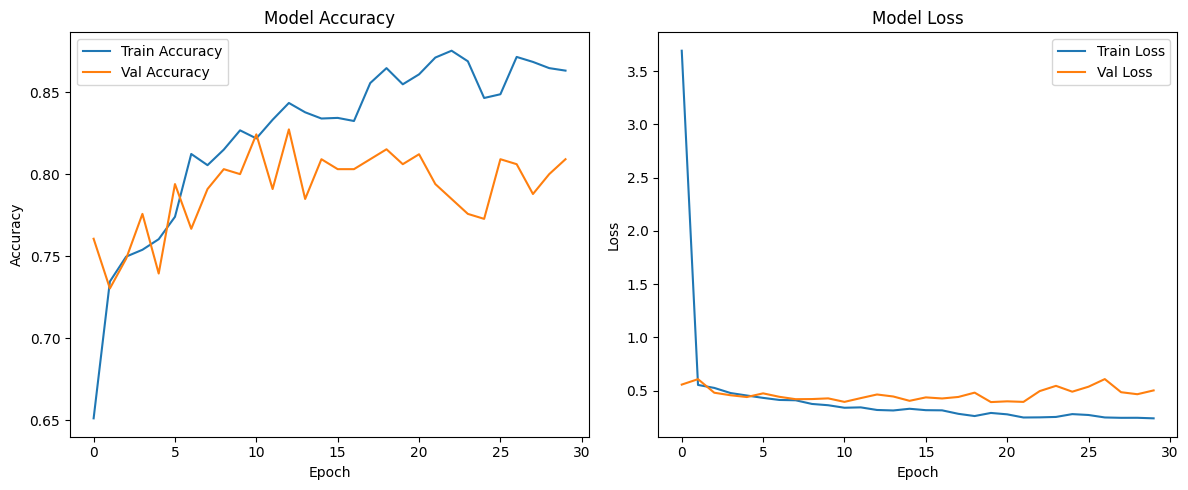

In [5]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Test Set

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Test Accuracy: 0.8121
Test Loss: 0.4152
Test Evaluation Time: 1.05 seconds


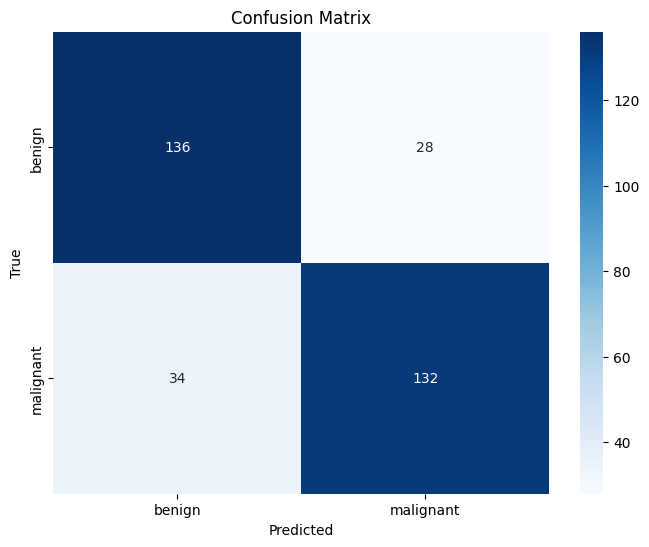


Classification Report:
              precision    recall  f1-score   support

      benign       0.80      0.83      0.81       164
   malignant       0.82      0.80      0.81       166

    accuracy                           0.81       330
   macro avg       0.81      0.81      0.81       330
weighted avg       0.81      0.81      0.81       330



In [6]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time

# Evaluate on test set
start_time = time.time()
test_loss, test_acc = model.evaluate(test_generator, verbose=0)
end_time = time.time()
test_time = end_time - start_time

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Evaluation Time: {test_time:.2f} seconds")

# Predict labels
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(label_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optional: classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


### Val Set


Val Accuracy: 0.8061
Val Loss: 0.3932
Val Evaluation Time: 1.09 seconds


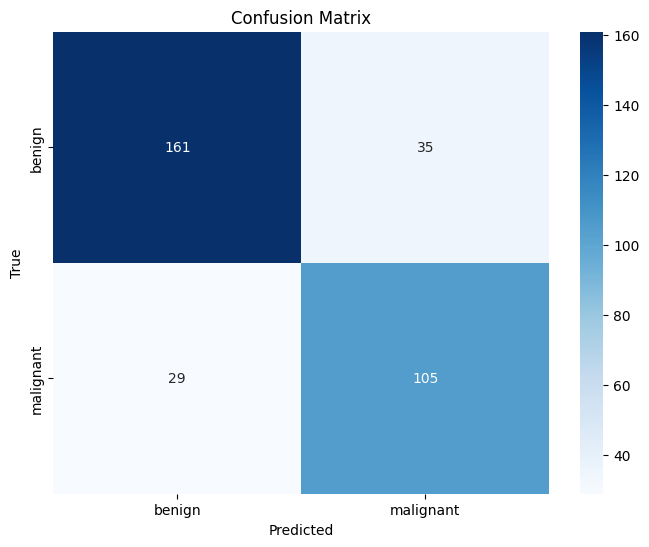


Classification Report:
              precision    recall  f1-score   support

      benign       0.85      0.82      0.83       196
   malignant       0.75      0.78      0.77       134

    accuracy                           0.81       330
   macro avg       0.80      0.80      0.80       330
weighted avg       0.81      0.81      0.81       330



In [7]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import time

# Evaluate on test set
start_time = time.time()
test_loss, test_acc = model.evaluate(val_generator, verbose=0)
end_time = time.time()
test_time = end_time - start_time

print(f"\nVal Accuracy: {test_acc:.4f}")
print(f"Val Loss: {test_loss:.4f}")
print(f"Val Evaluation Time: {test_time:.2f} seconds")

# Predict labels
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = val_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(label_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Optional: classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


## Finally saving the model

In [ ]:
import shutil

model.save('InceptionV3_model.keras')

destination = '/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/Base_Models/InceptionV3/InceptionV3_model.keras'
shutil.move('InceptionV3_model.keras', destination)

print(f'Model saved to {destination}')


Model saved to /content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/Base_Models/MobileNetV2/MobileNetV2_model.keras


## Load The model (If need)

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Student/Mohit/Model/Federated_Learning_Project_2/Base_Models/InceptionV3/InceptionV3_model.keras')
